In [1]:
# Load model directly
from transformers import AutoTokenizer, RobertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = RobertaForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import pandas as pd

path = "../data/CycPeptMPDB_Peptide_All.csv"
data = pd.read_csv(path, low_memory=False)

data = data.drop_duplicates(subset=['Structurally_Unique_ID'])
data = data[data['Permeability'] != -10]

target = data['Permeability']
smiles = data['SMILES']

In [3]:
def tokenize_smiles(smiles):
    """Tokenize SMILES strings using the ChemBERTa tokenizer."""
    return tokenizer(smiles, padding=True, truncation=True, return_tensors="pt")

features = tokenize_smiles(smiles.tolist())
print("Tokenization complete. Number of samples:", len(features['input_ids']))

Tokenization complete. Number of samples: 7718


In [4]:
from tqdm.notebook import tqdm

import torch

def get_embeddings(features, batch_size=64):
    model.eval()
    all_embeddings = []
    input_ids = features['input_ids']
    attention_mask = features['attention_mask']
    num_samples = input_ids.shape[0]
    for i in tqdm(range(0, num_samples, batch_size), desc="Embedding batches"):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_mask = attention_mask[i:i+batch_size]
        with torch.no_grad():
            outputs = model(
                input_ids=batch_input_ids,
                attention_mask=batch_attention_mask,
                output_hidden_states=True
            )
            last_hidden = outputs.hidden_states[-1]  # (batch_size, seq_len, hidden_dim)
            mask = batch_attention_mask.unsqueeze(-1).expand(last_hidden.size())
            summed = (last_hidden * mask).sum(1)
            counts = mask.sum(1)
            embeddings = summed / counts
            all_embeddings.append(embeddings)
    return torch.cat(all_embeddings, dim=0)

embeddings = get_embeddings(features)
print("Embeddings shape:", embeddings.shape)

Embedding batches:   0%|          | 0/121 [00:00<?, ?it/s]

Embeddings shape: torch.Size([7718, 384])


# Train the Model

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_jobs=-1))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(embeddings, target, test_size=0.2, random_state=42)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Ensemble averaging: train several RFs on different seeds and average predictions
n_ensemble = 20
ensemble_preds = []

for seed in range(n_ensemble):
    ensemble_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=seed, n_jobs=-1))
    ])
    ensemble_pipeline.fit(X_train, y_train)
    preds = ensemble_pipeline.predict(X_test)
    ensemble_preds.append(preds)
# Average predictions
y_pred = np.mean(ensemble_preds, axis=0)

# Calculate standard deviation of ensemble predictions for each sample
y_std = np.std(ensemble_preds, axis=0)
print(f"Mean prediction std across test set: {y_std.mean():.4f}")
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100
r2 = r2_score(y_test, y_pred)

print("Ensemble Test set performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.4f}")

Mean prediction std across test set: 0.0354
Ensemble Test set performance:
RMSE: 0.5358
MAE: 0.3946
MAPE: 6.78%
R2: 0.5493


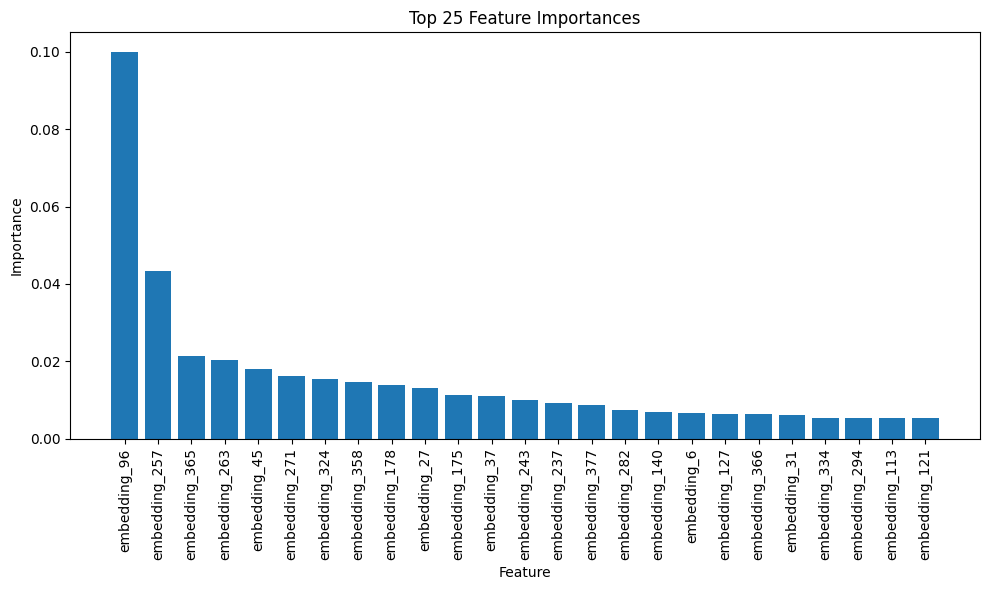

In [6]:
import matplotlib.pyplot as plt

# Print feature importances from the ensemble_pipeline's RandomForestRegressor
importances = ensemble_pipeline.named_steps['regressor'].feature_importances_
# Use generic embedding feature names
feature_names = [f"embedding_{i}" for i in range(len(importances))]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'][:25], feature_importance_df['Importance'][:25])
plt.xticks(rotation=90)
plt.title('Top 25 Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

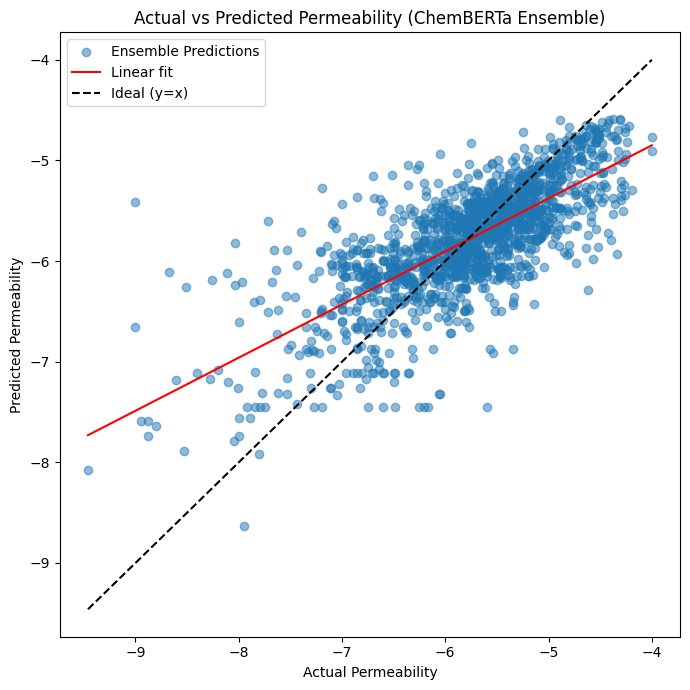

In [7]:
from sklearn.linear_model import LinearRegression

# Prepare data for regression line for the ensemble model
y_test_values = y_test.values.reshape(-1, 1)
y_pred_values = y_pred.reshape(-1, 1)

reg = LinearRegression()
reg.fit(y_test_values, y_pred_values)
line_x = np.linspace(y_test.min(), y_test.max(), 100).reshape(-1, 1)
line_y = reg.predict(line_x)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.5, label='Ensemble Predictions')
plt.plot(line_x, line_y, color='red', label='Linear fit')
plt.plot(line_x, line_x, color='black', linestyle='--', label='Ideal (y=x)')
plt.xlabel('Actual Permeability')
plt.ylabel('Predicted Permeability')
plt.title('Actual vs Predicted Permeability (ChemBERTa Ensemble)')
plt.legend()
plt.tight_layout()
plt.show()

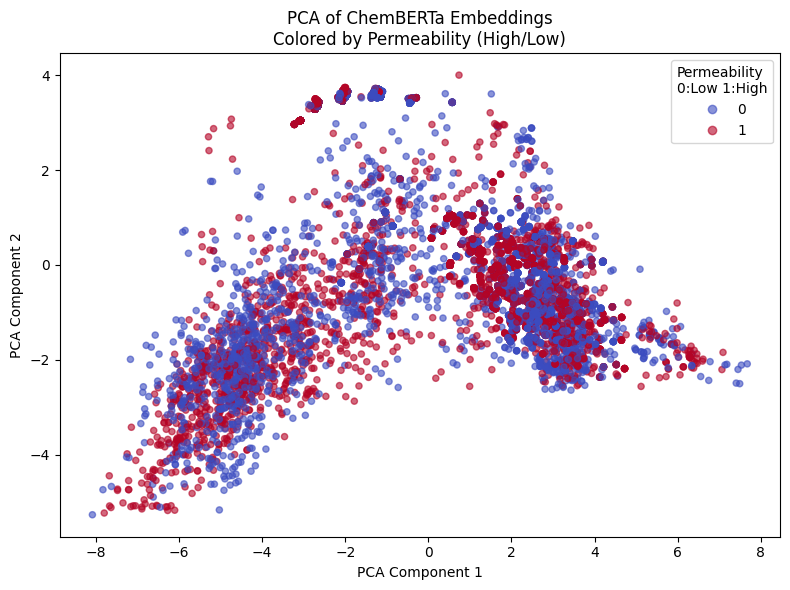

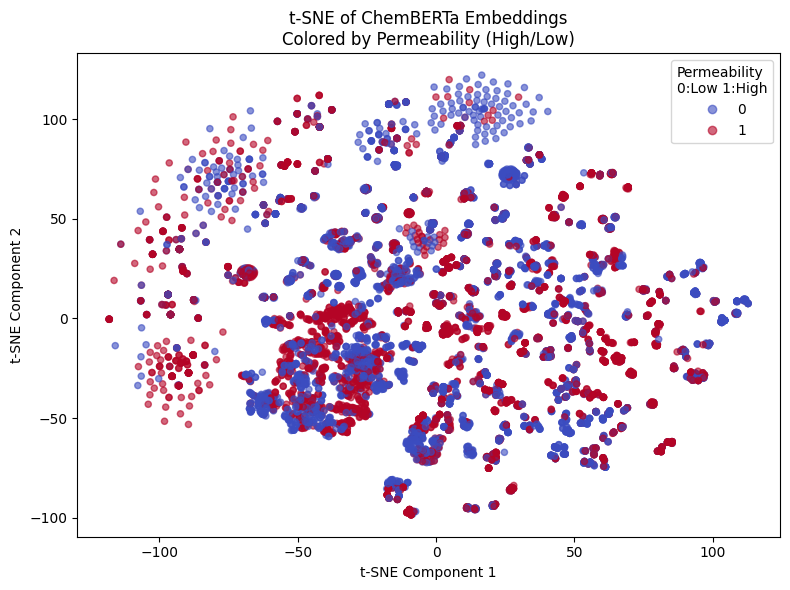

In [8]:
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from scipy.spatial import QhullError
from sklearn.cluster import DBSCAN

# Define high/low permeability threshold (e.g., median split)
threshold = target.median()
permeability_label = (target >= threshold).astype(int)  # 1: high, 0: low

# Use PCA for 2D visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=permeability_label, cmap='coolwarm', alpha=0.6, s=20
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of ChemBERTa Embeddings\nColored by Permeability (High/Low)')
plt.legend(*scatter.legend_elements(), title="Permeability\n0:Low 1:High")
plt.tight_layout()
plt.show()

# Compute t-SNE embeddings for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings.detach().cpu().numpy())

# t-SNE plot colored by permeability (high/low)
plt.figure(figsize=(8, 6))
scatter_perm = plt.scatter(
    embeddings_tsne[:, 0], embeddings_tsne[:, 1],
    c=permeability_label, cmap='coolwarm', alpha=0.6, s=20
)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of ChemBERTa Embeddings\nColored by Permeability (High/Low)')
plt.legend(*scatter_perm.legend_elements(), title="Permeability\n0:Low 1:High")
plt.tight_layout()
plt.show()

t-SNE: High permeability points: 3878, Low permeability points: 3840


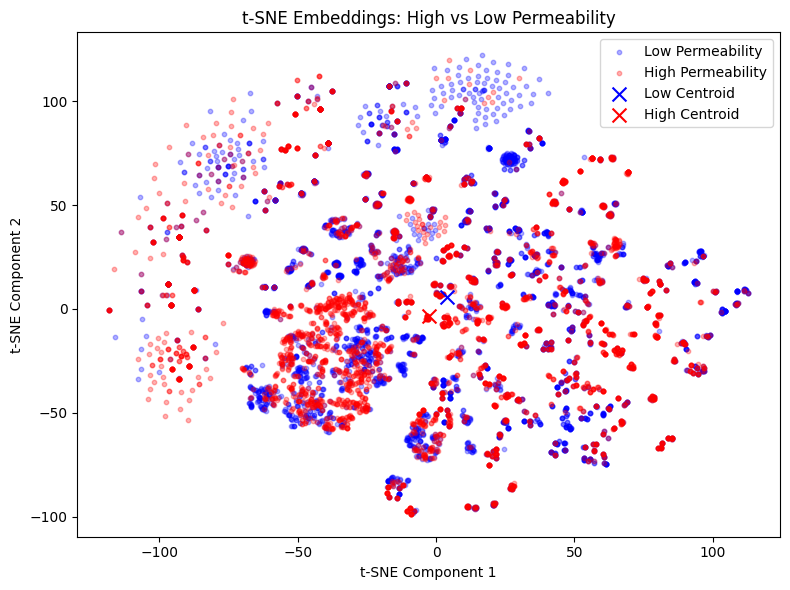

Centroid distance (t-SNE space): 11.33
Fraction of high permeability points inside low cluster hull: 99.10%
Fraction of low permeability points inside high cluster hull: 99.32%
t-SNE shows partial or poor separation between high and low permeability groups.


In [9]:
from scipy.spatial.distance import euclidean
from scipy.spatial import ConvexHull, Delaunay

# Analyze the t-SNE graph of ChemBERTa embeddings

# 1. Cluster separation: Check if high/low permeability points form distinct clusters
high_points = embeddings_tsne[permeability_label == 1]
low_points = embeddings_tsne[permeability_label == 0]

print(f"t-SNE: High permeability points: {high_points.shape[0]}, Low permeability points: {low_points.shape[0]}")

# 2. Visual inspection: Plot again with alpha and centroids
plt.figure(figsize=(8, 6))
plt.scatter(low_points[:, 0], low_points[:, 1], c='blue', alpha=0.3, s=10, label='Low Permeability')
plt.scatter(high_points[:, 0], high_points[:, 1], c='red', alpha=0.3, s=10, label='High Permeability')

# Centroids
low_centroid = low_points.mean(axis=0)
high_centroid = high_points.mean(axis=0)
plt.scatter(*low_centroid, c='blue', marker='x', s=100, label='Low Centroid')
plt.scatter(*high_centroid, c='red', marker='x', s=100, label='High Centroid')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Embeddings: High vs Low Permeability')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Quantitative separation: Compute centroid distance
centroid_dist = euclidean(low_centroid, high_centroid)
print(f"Centroid distance (t-SNE space): {centroid_dist:.2f}")

# 4. Overlap: Compute fraction of high points within convex hull of low points (and vice versa)

def fraction_inside(points, hull_points):
    hull = Delaunay(hull_points)
    return (hull.find_simplex(points) >= 0).mean()

low_hull = ConvexHull(low_points)
high_hull = ConvexHull(high_points)
frac_high_in_low = fraction_inside(high_points, low_points[low_hull.vertices])
frac_low_in_high = fraction_inside(low_points, high_points[high_hull.vertices])

print(f"Fraction of high permeability points inside low cluster hull: {frac_high_in_low:.2%}")
print(f"Fraction of low permeability points inside high cluster hull: {frac_low_in_high:.2%}")

# Summary
if centroid_dist > 10 and frac_high_in_low < 0.2 and frac_low_in_high < 0.2:
    print("t-SNE shows good separation between high and low permeability groups.")
else:
    print("t-SNE shows partial or poor separation between high and low permeability groups.")